# Set for jupyter notebook

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Env

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torchvision import transforms
import os
import random
from PIL import Image

In [3]:
from modules.dataset import get_loader
from modules.utils import imsshow, imgshow
from modules.network import UNet
from modules.loss import MyBinaryCrossEntropy
from modules.solver import Lab2Solver

In [4]:
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Data process

In [5]:
BG = [0]
RV = [85]
MYO = [170]
LV = [255]

train_loader = get_loader(image_root_path='./ACDC-2D-All/train/',palette=[RV,MYO,LV], batch_size=32, mode='train')
val_loader = get_loader(image_root_path='./ACDC-2D-All/val/', palette=[RV,MYO,LV], batch_size=32, mode='val')
test_loader = get_loader(image_root_path='./ACDC-2D-All/test/',palette=[RV,MYO,LV], batch_size=32, mode='test')

image count in train path :1394
image count in val path :200
image count in test path :204


torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])


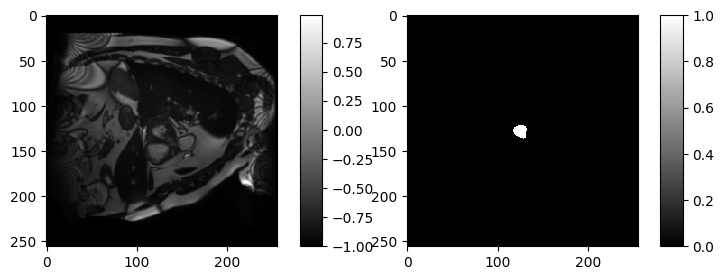

In [6]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(train_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)

idx = 10
# all_gt = (seg_gt[idx,1, :, :] * 85 + seg_gt[idx,2, :, :] * 170 + seg_gt[idx,3, :, :] * 255)/255
# imsshow([image[idx, 0, :, :], seg_gt[idx, 1, :, :],seg_gt[idx, 2, :, :],seg_gt[idx, 3, :, :], all_gt], is_colorbar=True, is_ticks=True)

imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :]], is_colorbar=True, is_ticks=True)
# target = all_gt
# unique, count = np.unique(target, return_counts=True)

# # Print the results
# for u, c in zip(unique, count):
#     print("Number of {} in the array: {}".format(u, c))

torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])


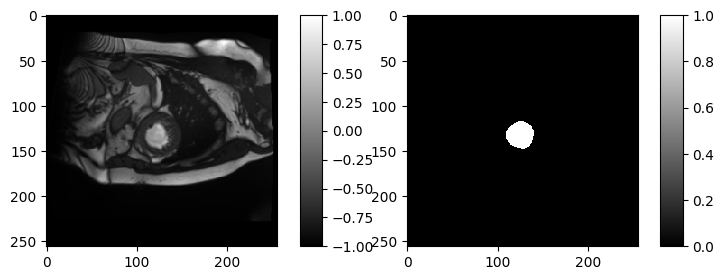

In [7]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(val_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)

idx = 5
# all_gt = (seg_gt[idx,1, :, :] * 85 + seg_gt[idx,2, :, :] * 170 + seg_gt[idx,3, :, :] * 255)/255
# imsshow([image[idx, 0, :, :]* 85, seg_gt[idx, 1, :, :],seg_gt[idx, 2, :, :],seg_gt[idx, 3, :, :], all_gt], is_colorbar=True, is_ticks=True)

imsshow([image[idx, 0, :, :], seg_gt[idx, 0, :, :]], is_colorbar=True, is_ticks=True)
# target = all_gt
# unique, count = np.unique(target, return_counts=True)

# # Print the results
# for u, c in zip(unique, count):
#     print("Number of {} in the array: {}".format(u, c))

# Network and Solver

In [8]:
net = UNet(n_channels=1, n_classes=1, C_base=32)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.95)

solver = Lab2Solver(
    model = net,
    optimizer = optimizer,
    criterion = MyBinaryCrossEntropy(),
    lr_scheduler=lr_scheduler,
    device="cuda:1"
)

# Train

  0%|          | 0/1394 [00:00<?, ?img/s]

[Validation] waiting:   0%|          | 0/200 [00:00<?, ?img/s]

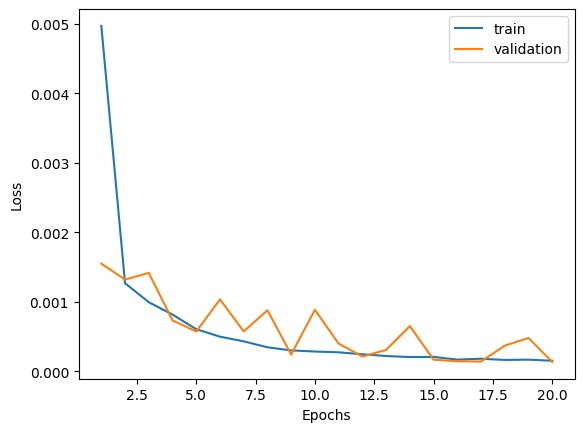

In [9]:
solver.train(
    epochs=20, 
    data_loader=train_loader,
    val_loader=val_loader
)

In [ ]:
import itertools

def fetch_batch_sample(loader, idx):
    batch = next(itertools.islice(loader, idx, None))
    return batch

batch = fetch_batch_sample(train_loader, idx=0)
image, seg_gt = batch
print(image.shape)
print(seg_gt.shape)
print(seg_gt.dtype)

torch.Size([32, 1, 256, 256])
torch.Size([32, 1, 256, 256])
torch.float32


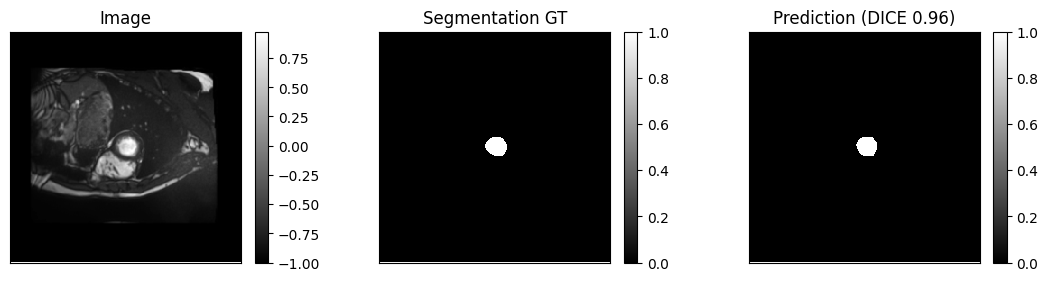

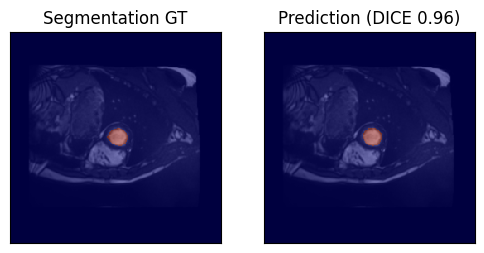

In [11]:
solver.visualize(test_loader, 12)

In [10]:
solver.validate(
    data_loader=test_loader
)

[Validation]:   0%|          | 0/204 [00:00<?, ?img/s]

============================== Measurements ==============================
[avg_Sensitivity] 0.9041591151801307
[avg_Specifity] 0.9994566428151855
[avg_Precision] 0.9122176858811935
[avg_F1Score] 0.9078365356670375
[avg_JaccardSimilarity] 0.831489685050394
[avg_DiceCoefficient] 0.9078370355142065


# Save checkpoint

In [24]:
import time
timestamp = time.strftime("%m-%d_%H-%M-%S", time.localtime())

In [26]:
name = "bad"
torch.save(net.state_dict(), f'./checkpoint/{timestamp}-{name}.pth')